# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Update note
November 2018 - Modified by Gaston Snaider under the course "Taller de Programacion III" of the University of Buenos Aires.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.
The network also ```requires a network_usage.log```, where the network usage speed per time is saved during the test.

## Input files
Here you should specify the input files and directories requiered for the test.

In [1]:
BATCHES_DIR = '/home/agustin/Desktop/LogsTestsMerged/Test2024-07-17/batch-reports'
TEST_CONFIG_FILE = '/home/agustin/Desktop/LogsTestsMerged/Test2024-07-17/src/description.yml'
NET_USAGE_FILE='/home/agustin/Desktop/LogsTestsMerged/Test2024-07-17/src/network_usage_torrents.log'
NET_USAGE_TIX_FILE='/home/agustin/Desktop/LogsTestsMerged/Test2024-07-17/src/network_usage_tix.log'

## Imports and setup

In [2]:
NET_USAGE_SEPARATOR='|'

# Setup and import everything
%matplotlib notebook
%matplotlib inline

import datetime
import math
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import openpyxl

from processor.reports.batch_handler import BatchHandler
from processor.analysis.analysis import Analyzer

from IPython.display import display

base_directory = BATCHES_DIR

## Test configuration
This is the configuration used during the test, as per the yaml file in TEST_CONFIG_FILE

In [4]:
with open(TEST_CONFIG_FILE) as fp:
    test_config = yaml.safe_load(fp)
test_config

{'intervals': [{'duration_minutes': 20, 'speed_percentage': 0},
  {'duration_minutes': 40, 'speed_percentage': 15},
  {'duration_minutes': 40, 'speed_percentage': 30},
  {'duration_minutes': 40, 'speed_percentage': 45},
  {'duration_minutes': 40, 'speed_percentage': 60},
  {'duration_minutes': 40, 'speed_percentage': 75},
  {'duration_minutes': 40, 'speed_percentage': 90},
  {'duration_minutes': 40, 'speed_percentage': 100},
  {'duration_minutes': 20, 'speed_percentage': 0}],
 'max_speed_kbps': 50000,
 'network_interface': 'wlan0',
 'start_time': 1721187900.12612}

/tmp/ipykernel_2440033/1599228746.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(interval_df, ignore_index=True)
/tmp/ipykernel_2440033/1599228746.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(interval_df, ignore_index=True)
/tmp/ipykernel_2440033/1599228746.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(interval_df, ignore_index=True)
/tmp/ipykernel_2440033/1599228746.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(interval_df, ignore_index=True)
/tmp/ipykernel_2440033/1599228746.py:11: FutureWarni

,start_time,end_time,expected_usage
0,2024-07-17 00:45:00.126120192,2024-07-17 01:05:00.126120192,0.00
1,2024-07-17 01:05:00.126120192,2024-07-17 01:45:00.126120192,0.15
2,2024-07-17 01:45:00.126120192,2024-07-17 02:25:00.126120192,0.30
3,2024-07-17 02:25:00.126120192,2024-07-17 03:05:00.126120192,0.45
4,2024-07-17 03:05:00.126120192,2024-07-17 03:45:00.126120192,0.60
5,2024-07-17 03:45:00.126120192,2024-07-17 04:25:00.126120192,0.75
6,2024-07-17 04:25:00.126120192,2024-07-17 05:05:00.126120192,0.90
7,2024-07-17 05:05:00.126120192,2024-07-17 05:45:00.126120192,1.00
8,2024-07-17 05:45:00.126120192,2024-07-17 06:05:00.126120192,0.00


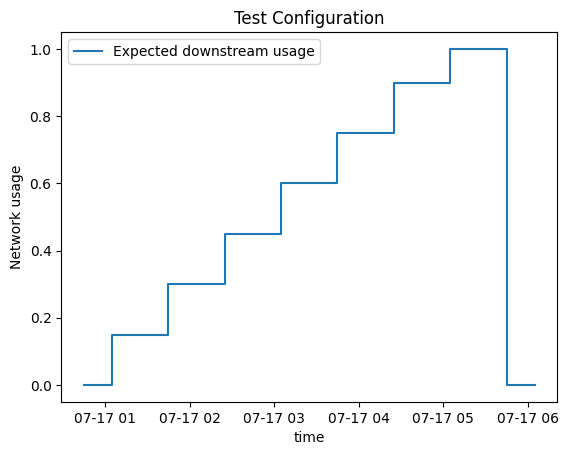

In [5]:
def get_test_expected_downstream_usage():
    columns = ["start_time", "end_time", "expected_usage"]
    test_data = pd.DataFrame(columns=columns)
    test_start = test_config['start_time']
    for test_interval in test_config['intervals']:
        interval_duration = test_interval['duration_minutes'] * 60
        end_time = test_start + interval_duration
        interval_df = pd.DataFrame([(test_start, end_time, test_interval['speed_percentage']/100)], columns=columns)
        interval_df['start_time'] = pd.to_datetime(interval_df['start_time'],unit='s')
        interval_df['end_time'] = pd.to_datetime(interval_df['end_time'],unit='s')
        test_data = test_data.append(interval_df, ignore_index=True)
        test_start = end_time
    test_data['start_time'] = test_data['start_time'] - pd.Timedelta('03:00:00')
    test_data['end_time'] = test_data['end_time'] - pd.Timedelta('03:00:00')
    return test_data

test_data = get_test_expected_downstream_usage()
test_data = test_data.sort_values(by=['start_time'])
display(test_data)

plt.figure()
# This line is done to get the last step shown in the plot.
test_data.loc[len(test_data.index)] = [test_data['end_time'][len(test_data.index)-1],test_data['end_time'][len(test_data.index)-1] + pd.Timedelta('00:30:00'), 0.00] 
plt.step(test_data['start_time'],  test_data['expected_usage'], where='post')
plt.xlabel('time')
plt.ylabel('Network usage')
plt.title('Test Configuration')
plt.legend(['Expected downstream usage'])
plt.show()

## Measued and expected network usage
Here we calculate the network usage as measured by the TiX system, and the expected network usage based on the test configuration.

In [6]:
def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    test_start_epoch = test_config['start_time']
    experiment_start_epoch = test_start_epoch
    for experiment_configuration in test_config['intervals']:
        experiment_lapse = experiment_configuration['duration_minutes'] * 60
        experiment_start = experiment_start_epoch
        experiment_end = experiment_start_epoch + experiment_lapse
        if experiment_start <= batch_start_time < experiment_end:
            batch_starting_conf = experiment_configuration
            batch_starting_conf_start_epoch = experiment_start
        if experiment_start <= batch_end_time < experiment_end:
            batch_ending_conf = experiment_configuration
            batch_ending_conf_start_epoch = experiment_start
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
        # Increment the start epoch for the next experiment.
        experiment_start_epoch = experiment_end
  
    if batch_starting_conf is None and batch_ending_conf is None:
        return None
#         raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
#                                                                                           batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed_percentage'] / 100
    elif batch_starting_conf['speed_percentage'] / 100 == batch_ending_conf['speed_percentage'] / 100:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    else:
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf_start_epoch + batch_starting_conf['duration_minutes']*60 - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf_start_epoch
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed_percentage'] / 100 +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed_percentage'] / 100)
    return expected_usage
    

In [7]:
columns = ['batch_start_timestamp', 'batch_end_timestamp',
           'batch_start_time', 'batch_end_time',
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage', 'error', 'relative_error',
           'LongitudMediciones', 'Min', 'Max', 'Q25', 'Q50', 'Q75', 'ModeIndex'
          ]
data = pd.DataFrame(columns=columns)

batch_handler = BatchHandler(base_directory)
observations = batch_handler.load_batches_and_get_observations()
if observations is None or len(observations) == 0:
    raise ValueError('Batches directory {} has no observations to use!'.format(base_directory))

ten_minutes_observations = []
observations_to_delete = []
batches = batch_handler.get_batches()
for i in range(len(batches) - 1):
  batch = batches[i]
  batch_start_time = int(batch.initial_timestamp)
  batch_end_time = int(batch.final_timestamp)
  expected_usage = get_expected_usage(batch_start_time, batch_end_time)
  observations_to_delete.append(len(observations[i]))
  ten_minutes_observations.extend(observations[i])
  if (i >= 9):
    analyzer = Analyzer(ten_minutes_observations)
    results = analyzer.get_results()
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         datetime.datetime.fromtimestamp(batch_start_time),
                         datetime.datetime.fromtimestamp(batch_end_time),
                           results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                           results['downstream']['quality'], results['downstream']['usage'], 
                           results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                           results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage, 
                         math.fabs(expected_usage - results['downstream']['usage']), 
                         (math.fabs(expected_usage - results['downstream']['usage']) / expected_usage) 
                         if expected_usage != 0 else math.fabs(expected_usage - results['downstream']['usage']),
                           results['dataFromReport']['LongMediciones'],
                           results['dataFromReport']['Minimo'],
                           results['dataFromReport']['Maximo'],
                           results['dataFromReport']['Q25'],
                           results['dataFromReport']['Q50'],
                           results['dataFromReport']['Q75'],
                           results['dataFromReport']['ModeIndex']
                          )
                      ], 
                        columns=columns)
    del ten_minutes_observations[:observations_to_delete[0]]
    observations_to_delete.pop(0)
  else:
     df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                          datetime.datetime.fromtimestamp(batch_start_time),
                          datetime.datetime.fromtimestamp(batch_end_time),
                          '-', '-','-', '-', '-','-', '-','-',
                          expected_usage, 
                          '-', '-', '-','-', '-', '-','-', '-','-',
                          )
                      ], 
                        columns=columns)
  data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)
data.to_excel("excels/data.xlsx")

/tmp/ipykernel_2440033/935069022.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df_)
/tmp/ipykernel_2440033/935069022.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df_)
/tmp/ipykernel_2440033/935069022.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df_)
/tmp/ipykernel_2440033/935069022.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df_)
/tmp/ipykernel_2440033/935069022.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df_)
/tmp/

,batch_start_timestamp,batch_end_timestamp,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,...,expected_downstream_usage,error,relative_error,LongitudMediciones,Min,Max,Q25,Q50,Q75,ModeIndex
0,1721187971,1721187993,2024-07-17 00:46:11,2024-07-17 00:46:33,-,-,-,-,-,-,...,0.0,-,-,-,-,-,-,-,-,-
1,1721187995,1721188058,2024-07-17 00:46:35,2024-07-17 00:47:38,-,-,-,-,-,-,...,0.0,-,-,-,-,-,-,-,-,-
2,1721188060,1721188123,2024-07-17 00:47:40,2024-07-17 00:48:43,-,-,-,-,-,-,...,0.0,-,-,-,-,-,-,-,-,-
3,1721188125,1721188188,2024-07-17 00:48:45,2024-07-17 00:49:48,-,-,-,-,-,-,...,0.0,-,-,-,-,-,-,-,-,-
4,1721188190,1721188253,2024-07-17 00:49:50,2024-07-17 00:50:53,-,-,-,-,-,-,...,0.0,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,1721206780,1721206843,2024-07-17 05:59:40,2024-07-17 06:00:43,0.610072,0.706641,0,0.410989,0.526916,0.522626,...,0.0,0.410989,0.410989,0,0,0,0,0,0,0
291,1721206845,1721206908,2024-07-17 06:00:45,2024-07-17 06:01:48,0.64056,0.745302,0,0.341935,0.525272,0.512353,...,0.0,0.341935,0.341935,0,0,0,0,0,0,0
292,1721206910,1721206973,2024-07-17 06:01:50,2024-07-17 06:02:53,0.550476,0.691612,0,0.337079,0.503591,0.085839,...,0.0,0.337079,0.337079,0,0,0,0,0,0,0
293,1721206975,1721207038,2024-07-17 06:02:55,2024-07-17 06:03:58,0.55697,0.685314,0,0.303738,0.488416,0.3409,...,0.0,0.303738,0.303738,0,0,0,0,0,0,0


## Actual network usage
Here we process the data from NET_USAGE_FILE, which corresponds to the network usage measured in the specified network_interface during the test.

We group the network usage data into batches so that they match the structure of the batches from the TiX measurements.

NOTE: for the comparison between the network usage and the TiX measurements to work, it is required that the network usage was measured once per minute on the test, and that the measurements started at the same time as the TiX client.

In [8]:

net_usage = 0
net_stat_lines_cont = 0
grouped_net_usage = []
start_time_in_group = []

with open(NET_USAGE_FILE) as net_usage_file:
  lines = net_usage_file.readlines()
  for i in range(len(batches)):
    if (i < 9):
      continue
    current_batch = batches[i]
    batch_end_time = int(current_batch.final_timestamp)
    batch_start_time = int(batches[i-9].initial_timestamp)
    print("Batch start time: {}".format(batch_start_time))
    print("Batch end time: {}".format(batch_end_time))

    for line in lines:
      if line == lines[0]:
        continue
      (epoch, speed) = line.split(NET_USAGE_SEPARATOR)
      usage_timestamp =  int(str(epoch).split('.')[0])
      print("Usage timestamp: {}".format(usage_timestamp))
      speed_kbps = float(speed)

      if (batch_start_time <= usage_timestamp <= batch_end_time):
        net_usage += speed_kbps
        net_stat_lines_cont += 1
      elif batch_end_time < usage_timestamp:
        grouped_net_usage.append((net_usage/net_stat_lines_cont)/test_config['max_speed_kbps'])
        net_usage = 0
        net_stat_lines_cont = 0
        start_time_in_group.clear()
        break


actual_usage = pd.DataFrame([], columns=['downstream_actual_usage'])
actual_usage = actual_usage.assign(downstream_actual_usage=grouped_net_usage)
actual_usage.to_excel('excels/actual_downstream.xlsx')


Batch start time: 1721187971
Batch end time: 1721188578
Usage timestamp: 1721187971
Usage timestamp: 1721188032
Usage timestamp: 1721188093
Usage timestamp: 1721188154
Usage timestamp: 1721188215
Usage timestamp: 1721188276
Usage timestamp: 1721188337
Usage timestamp: 1721188398
Usage timestamp: 1721188459
Usage timestamp: 1721188521
Usage timestamp: 1721188582
10
Batch start time: 1721187995
Batch end time: 1721188643
Usage timestamp: 1721187971
Usage timestamp: 1721188032
Usage timestamp: 1721188093
Usage timestamp: 1721188154
Usage timestamp: 1721188215
Usage timestamp: 1721188276
Usage timestamp: 1721188337
Usage timestamp: 1721188398
Usage timestamp: 1721188459
Usage timestamp: 1721188521
Usage timestamp: 1721188582
Usage timestamp: 1721188643
Usage timestamp: 1721188704
11
Batch start time: 1721188060
Batch end time: 1721188708
Usage timestamp: 1721187971
Usage timestamp: 1721188032
Usage timestamp: 1721188093
Usage timestamp: 1721188154
Usage timestamp: 1721188215
Usage timestam